## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. 

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1. 

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. 

What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: xlabel='Frequency', ylabel='Count'>

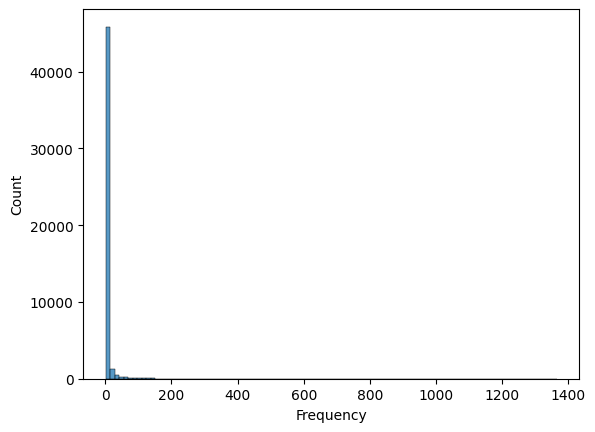

In [ ]:
# oh my god it took me so long to figure out what you guys
# wanted me to be understanding with this histogram
token_frequency_df = pd.DataFrame(token_freq, columns=['Token', 'Frequency'])
sns.histplot(token_frequency_df['Frequency'], bins=100)

Looks like there are a ton of words that only appear maybe once or twice or a few times - basically, tons of words that don't show up a lot in emails. This data is extremely skewed. There are also a decent (but much smaller count, obviously) number of words that have higher frequencies in emails. Also judging by the fact that the x-axis goes all the way to 1400, it can be assumed that there are bins where words show up with high frequency (but not many of them since you can't actually see those bins).

### Q2. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

#### Q2.1

In [3]:
phishing_df = pd.read_parquet('./data/Phishing_clean.parquet')

In [6]:
phishing_df.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = phishing_df.drop(columns=['Email Type'])
y = phishing_df['Email Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=250113)

#### Q2.2

In [13]:
linear_model = LinearRegression().fit(X_train, y_train)

print("Train R^2:")
print(linear_model.score(X_train, y_train))
print("Test R^2:")
print(linear_model.score(X_test, y_test))

Train R^2:
0.7657884190518023
Test R^2:
0.6717871602654365


#### Q2.3

OK. So doing `reg.coef_` would give me the coefficients - let me just then bind that with the columns of X_train, and then also add a column that's the absolute value of `reg.coef_` and we should be good?

In [19]:
words_coefs = pd.DataFrame({'word': X_train.columns, 'coefficient': linear_model.coef_, 'abs_coefficient': np.abs(linear_model.coef_)})
words_coefs.sort_values(by='abs_coefficient', ascending=False).head(10)

,word,coefficient,abs_coefficient
1504,background-image:,-0.877631,0.877631
740,localized,0.725690,0.725690
1406,"helvetica,",0.626966,0.626966
1839,form.,0.626414,0.626414
2362,thermal,0.612402,0.612402
2094,#000000;,0.604700,0.604700
2666,#331f30;,0.604700,0.604700
906,aging,0.546590,0.546590
1245,{text-decoration:,0.518355,0.518355
2532,xanaax,0.503178,0.503178


So looks like having a background image, the word "localized", helvetica font, a form, and the word "thermal" are all high up here. Some other notable ones are #000000 and #331f30, which are just black and gray, so maybe it's just that if there's HTML or anything specified within the email it may be more likely to be a scam (except the background image).

### Q3. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

Ok. This reads like it wants me to actually use the original df, so I'll be doing that.

<Axes: xlabel='pc1', ylabel='pc2'>

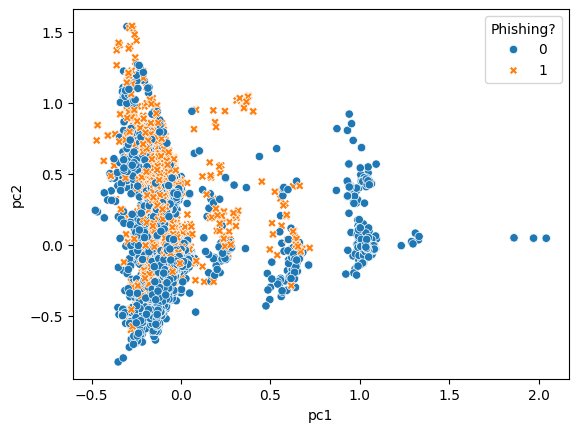

In [26]:
def demean(x):
    xbar = np.mean(x)
    z = x-xbar
    return(z)

token_features = phishing_df.drop(columns=['Email Type'])
# i assume I need to demean them like we did in the lecture file?
demeaned_token_features = token_features.apply(demean)

PCA_model = PCA(n_components=2)
PCA_model.fit(demeaned_token_features)
Z_token_features = PCA_model.transform(demeaned_token_features)

gdf = pd.DataFrame({'pc1': Z_token_features[:,0], 'pc2': Z_token_features[:,1], 'Phishing?': phishing_df['Email Type']})
sns.scatterplot(data=gdf,x='pc1', y='pc2',hue='Phishing?',style='Phishing?')

Honestly, not any super duper clear patterns here. The only notable things are that there's a huge cluster of data on the left side of whatever the pc1 values are, and few groups out to the right - as pc1 increases, seems to be only none-phishing cases. That being said, looks like it's not easily separable by just using these two components. We may need more to actually optimally filter what is necessary for prediction and what's not, since clearly two components isn't enough.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [28]:
X = phishing_df.drop(columns=['Email Type'])
y = phishing_df['Email Type']

demeaned_X = X.apply(demean)
X_train, X_test, y_train, y_test = train_test_split(demeaned_X, y, test_size=0.2, random_state=250113)

PCA_model = PCA(n_components=2610)
PCA_model.fit(X_train)
pca_train = PCA_model.transform(X_train)
pca_test = PCA_model.transform(X_test)

linear_model = LinearRegression().fit(pca_train, y_train)

print("Train R^2:")
print(linear_model.score(pca_train, y_train))
print("Test R^2:")
print(linear_model.score(pca_test, y_test))

Train R^2:
0.7651516938618348
Test R^2:
0.6724741170391254


Yo... I'm gonna be real. The train and test R^2 like, **barely** improved. Which kinda makes sense given that PCA is mostly for dimensionality reduction so we're just slamming together highly correlated features which may reduce noise? Idk in any case that's the analysis lol.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The advantage in using the principal components rather than the original data is probably just that you now have a slightly tighter feature space (2610, instead of 2711) which means that the model takes into account a few less components. In an optimal situation the selected components that were "reduced" were probably redundant/noisy and thus the model may perform better due to less features/less overfitting.